# **Project: Amazon Product Recommendation System**



Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.



## **Context:**



Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.



## **Objective:**



You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.


## **Dataset:**


The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [27]:
import pandas as pd

#File location and reading data file
file_path = '/content/drive/My Drive/ratings_Electronics.csv'
df = pd.read_csv(file_path)

# Previewing the data
print(df.head())

    AKM1MP6P0OYPR  0132793040  5.0  1365811200
0  A2CX7LUOHB2NDG  0321732944  5.0  1341100800
1  A2NWSAGRHCP8N5  0439886341  1.0  1367193600
2  A2WNBOD3WNDNKT  0439886341  3.0  1374451200
3  A1GI0U4ZRJA8WN  0439886341  1.0  1334707200
4  A1QGNMC6O1VW39  0511189877  5.0  1397433600


**Installing surprise library**

In [28]:
!pip install scikit-surprise


In [29]:
import surprise
print(surprise.__version__)


1.1.4


In [30]:
from surprise import Dataset, Reader  # Load and preprocess dataset
from surprise import SVD, KNNBasic, KNNWithMeans, KNNBaseline  # Recommendation algorithms
from surprise import accuracy  # Evaluation metrics (RMSE, MAE)
from surprise.model_selection import cross_validate, train_test_split  # Train-test split & validation
from surprise import BaselineOnly, NormalPredictor
from surprise.model_selection import GridSearchCV


## **Importing the necessary libraries and overview of the dataset**

In [31]:
# Importing the basic libraries we will require for the project

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier



**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [32]:
# Define column names based on dataset description
column_names = ['user_id', 'prod_id', 'rating', 'timestamp']

# Load the CSV while assigning column names
df = pd.read_csv("ratings_Electronics.csv", names=column_names)

# Drop the 'timestamp' column if not needed
df.drop(columns=['timestamp'], inplace=True)

# Display the first few rows to verify
print(df.head())

print(df.columns)

          user_id     prod_id  rating
0   AKM1MP6P0OYPR  0132793040     5.0
1  A2CX7LUOHB2NDG  0321732944     5.0
2  A2NWSAGRHCP8N5  0439886341     1.0
3  A2WNBOD3WNDNKT  0439886341     3.0
4  A1GI0U4ZRJA8WN  0439886341     1.0
Index(['user_id', 'prod_id', 'rating'], dtype='object')


In [34]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [35]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [36]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [37]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [38]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [39]:
df_final.describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [41]:
# Check the number of rows and columns and provide observations
num_rows, num_columns = df_final.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Number of rows: 65290
Number of columns: 3


There are 65290 rows and 3 columns in the data we will be using.

### **Data types**

In [42]:
# Check Data types and provide observations
print("Data Types of Each Column:")
print(df_final.dtypes)

Data Types of Each Column:
user_id     object
prod_id     object
rating     float64
dtype: object


There are 2 columns with objects data type and 1 column with float data type.

### **Checking for missing values**

In [45]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()

# Print missing values count
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
user_id    0
prod_id    0
rating     0
dtype: int64


No missing values were found.

### **Summary Statistics**

In [46]:
# Summary statistics of 'rating' variable and provide observations
print("Summary Statistics of 'rating' Variable:")
print(df_final['rating'].describe())

Summary Statistics of 'rating' Variable:
count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


The summary statistics indicate that there are 65,290 ratings in the dataset. The average rating is 4.29, with a standard deviation of 0.99, meaning most ratings are close to the average. The minimum rating is 1, and the maximum is 5. The median (50%) rating is 5, and 75% of ratings are 5, suggesting users tend to give high ratings.

### **Checking the rating distribution**

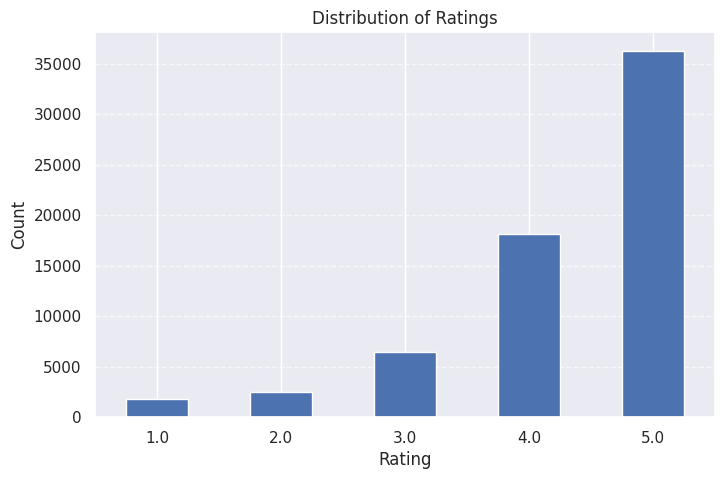

In [47]:
# Plot bar chart for rating distribution
plt.figure(figsize=(8, 5))
df_final['rating'].value_counts().sort_index().plot(kind='bar')

# Labels and title
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


Observations:
As seen above, The majority of the ratings are 4 and 5, indicating positive user experiences. Lower ratings such as 1, 2, and 3 are significantly less frequent. This suggests that most users are satisfied with the products, and there may be a bias towards high ratings.


### **Checking the number of unique users and items in the dataset**

In [51]:
# Total number of rows
total_rows = df_final.shape[0]

# Number of unique users
unique_users = df_final["user_id"].nunique()

# Number of unique products
unique_products = df_final["prod_id"].nunique()

# Print results
print(f"Total number of rows: {total_rows}")
print(f"Number of unique user IDs: {unique_users}")
print(f"Number of unique product IDs: {unique_products}")

Total number of rows: 65290
Number of unique user IDs: 1540
Number of unique product IDs: 5689


### **Users with the most number of ratings**

In [52]:
# Top 10 users based on the number of ratings
# Get the top 10 users based on the number of ratings
top_users = df['user_id'].value_counts().head(10)

print("Top 10 Users Based on Number of Ratings:")
print(top_users)

Top 10 Users Based on Number of Ratings:
user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: count, dtype: int64


**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [55]:
# Calculate the average rating for each product
avg_rating = df_final.groupby("prod_id")["rating"].mean()
print(f"Average rating for each product:\n{avg_rating}")

# Calculate the count of ratings for each product
rating_count = df_final.groupby("prod_id")["rating"].count()
print(f"\nCount of ratings for each product:\n{rating_count}")

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({"avg_rating": avg_rating, "rating_count": rating_count})

# Print the first few rows of the final_rating dataframe
print("\nFirst few rows of final_rating dataframe:")
print(final_rating.head())

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by="avg_rating", ascending=False)

# See the first five records of the "final_rating" dataset
print(final_rating.head())


Average rating for each product:
prod_id
1400501466    3.333333
1400532655    3.833333
1400599997    4.000000
9983891212    4.875000
B00000DM9W    5.000000
                ...   
B00L21HC7A    4.625000
B00L2442H0    4.916667
B00L26YDA4    4.384615
B00L3YHF6O    5.000000
B00LGQ6HL8    5.000000
Name: rating, Length: 5689, dtype: float64

Count of ratings for each product:
prod_id
1400501466     6
1400532655     6
1400599997     5
9983891212     8
B00000DM9W     5
              ..
B00L21HC7A    16
B00L2442H0    12
B00L26YDA4    13
B00L3YHF6O    14
B00LGQ6HL8     5
Name: rating, Length: 5689, dtype: int64

First few rows of final_rating dataframe:
            avg_rating  rating_count
prod_id                             
1400501466    3.333333             6
1400532655    3.833333             6
1400599997    4.000000             5
9983891212    4.875000             8
B00000DM9W    5.000000             5
            avg_rating  rating_count
prod_id                             
B00LGQ6HL8     

In [56]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(final_rating, n=10, min_interactions=50):
    """
    Function to get top N products based on highest average rating and minimum interactions. """

    # Filter products that have at least 'min_interactions' number of ratings
    filtered_products = final_rating[final_rating['rating_count'] >= min_interactions]

    # Sort by average rating in descending order
    top_products = filtered_products.sort_values(by="avg_rating", ascending=False).head(n)

    return top_products

# Finding products with minimum number of interactions
min_interactions = 50

# Get top 10 products based on ratings and minimum interactions
top_products = get_top_n_products(final_rating, n=10, min_interactions=min_interactions)

# Sorting values with respect to average rating
print(top_products)


            avg_rating  rating_count
prod_id                             
B001TH7GUU    4.871795            78
B003ES5ZUU    4.864130           184
B0019EHU8G    4.855556            90
B006W8U2MU    4.824561            57
B000QUUFRW    4.809524            84
B000HPV3RW    4.803922            51
B001TH7GSW    4.803279            61
B000BQ7GW8    4.777778            54
B000N99BBC    4.772455           167
B002WE6D44    4.770000           100


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [57]:
# Since most of the steps to achieving this has been adjusted previously, here are additional codes to recommend top 5 products based on popularity.

# Filter products with at least 50 ratings (minimum interactions)
min_interactions = 50
popular_products = final_rating[final_rating["rating_count"] >= min_interactions]

# Sort by rating count (popularity) in descending order
top_5_popular_products = popular_products.sort_values(by="rating_count", ascending=False).head(5)

# Display the top 5 popular products
print("Top 5 Popular Products with at least 50 Interactions:")
print(top_5_popular_products)


Top 5 Popular Products with at least 50 Interactions:
            avg_rating  rating_count
prod_id                             
B0088CJT4U    4.218447           206
B003ES5ZUU    4.864130           184
B000N99BBC    4.772455           167
B007WTAJTO    4.701220           164
B00829TIEK    4.436242           149


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [58]:
# Since most of the steps to achieving this has been adjusted previously, here are additional codes to recommend top 5 products based on popularity.

# Filter products with at least 100 ratings (minimum interactions)
min_interactions = 100
popular_products = final_rating[final_rating["rating_count"] >= min_interactions]

# Sort by rating count (popularity) in descending order
top_5_popular_products = popular_products.sort_values(by="rating_count", ascending=False).head(5)

# Display the top 5 popular products
print("Top 5 Popular Products with at least 100 Interactions:")
print(top_5_popular_products)

Top 5 Popular Products with at least 100 Interactions:
            avg_rating  rating_count
prod_id                             
B0088CJT4U    4.218447           206
B003ES5ZUU    4.864130           184
B000N99BBC    4.772455           167
B007WTAJTO    4.701220           164
B00829TIEK    4.436242           149


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [59]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [60]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [65]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[["user_id", "prod_id", "rating"]], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print("Data successfully loaded and split into training and testing sets.")
print(f"Number of training interactions: {trainset.n_ratings}")
print(f"Number of testing interactions: {len(testset)}")

Data successfully loaded and split into training and testing sets.
Number of training interactions: 52232
Number of testing interactions: 13058


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [67]:
# Declaring the similarity options
sim_options = {
    "name": "cosine",  # Use Cosine similarity
    "user_based": True,  # User-User similarity
}


# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
# Initialize the KNNBasic model using the declared similarity options
model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)


# Fit the model on the training data
model.fit(trainset)

print("Model training completed.")


# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
from collections import defaultdict

def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all predicted precisions
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all predicted recalls
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Compute RMSE
    accuracy.rmse(predictions)

    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1-score@{k}: {round((2 * precision * recall) / (precision + recall), 3)}")

# Compute precision, recall, and F1-score
precision_recall_at_k(model, k=10, threshold=3.5)


Model training completed.
RMSE: 1.0012
Precision@10: 0.855
Recall@10: 0.858
F1-score@10: 0.856


Here is what the output says:
1. RMSE (1.0012): This measures the difference between the actual and predicted ratings. A lower RMSE is better, and 1.0012 suggests the model's predictions are fairly close to actual ratings.  
2. Precision@10 (0.855): This means 85.5% of the recommended items in the top 10 were actually relevant, showing high recommendation accuracy.  
3. Recall@10 (0.858): The model successfully captured 85.8% of all relevant items in the top 10 recommendations, indicating strong recall.  
4. F1-score@10 (0.856): Since F1-score is the harmonic mean of precision and recall, a score of 0.856 means the model maintains a great balance between both.  
5. High Precision & Recall: The model is highly effective in suggesting relevant products and ensuring users receive quality recommendations.  
6. Slight RMSE Error: Although RMSE is slightly above 1, it's within an acceptable range, implying the model still performs well in predicting user preferences.  
7. Overall Performance: The model is well-tuned, capturing relevant items efficiently while maintaining minimal prediction error, making it a strong baseline recommender system.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [68]:
# Predicting rating for a sample user with an interacted product
# Predict the rating for a specific user-product pair
user_id = "A3LDPF5FMB782Z"
prod_id = "1400501466"

# Using the trained model to predict the rating
predicted_rating = model.predict(user_id, prod_id)

# Display the predicted rating
print(f"Predicted rating for User {user_id} on Product {prod_id}: {predicted_rating.est:.2f}")


Predicted rating for User A3LDPF5FMB782Z on Product 1400501466: 3.40


Below is the **list of users who have not seen the product with product id "1400501466"**.

In [77]:
# Find unique user_id where prod_id is not equal to "1400501466"
filtered_users = df_final[df_final["prod_id"] != "1400501466"]["user_id"].unique()

# Display unique user IDs
print("Number of unique users (excluding product 1400501466):", len(filtered_users))
print("Sample user IDs:", filtered_users[:300])


Number of unique users (excluding product 1400501466): 1540
Sample user IDs: ['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' 'A1P4XD7IORSEFN'
 'A341HCMGNZCBIT' 'A3HPCRD9RX351S' 'A1DQHS7MOVYYYA' 'ALUNVOQRXOZIA'
 'A19N3S7CBSU6O7' 'A3G7BEJJCPD6DS' 'A2JXS1JII6SAUD' 'A1C82BC5GNABOA'
 'A1VHCO8RQFIGQJ' 'A2Z9S2RQD542CP' 'A2QIC4G483SQQA' 'A3L6L5O89JTX2T'
 'A1OGCPMSIVK7G4' 'A18HE80910BTZI' 'A3F9CBHV4OHFBS' 'A1T1YSCDW0PD25'
 'ABVYGB2TKBO8F' 'A11ED8O95W2103' 'A3NCIN6TNL0MGA' 'ASHJAZC9OA9NS'
 'A105TOJ6LTVMBG' 'A14JBDSWKPKTZA' 'A3QX0ERX4D03TF' 'A13WREJ05GMRA6'
 'A3N8O68DOEQ2FE' 'A3J8A5L5AF5TX9' 'A2HRHF83I3NDGT' 'A1R3GN9MEJFXM3'
 'A3963R7EPE3A7E' 'A2JOPUWVV0XQJ3' 'AAW7X3GRD8GY9' 'A3V8P0O224OBDB'
 'AY6A8KPYCE6B0' 'A212MDP6K4VJS5' 'A28X0LT2100RL1' 'A1V3TRGWOMA8LC'
 'A1NZLRAZJGD99W' 'A1522TN5FVJL0Y' 'A3UXW18DP4WSD6' 'A3CW0ZLUO5X2B1'
 'A3TBMGNSEQBWIL' 'AEZJTA4KDIWY8' 'A22CW0ZHY3NJH8' 'A2V7EO331SFUF6'
 'A3977M5S0GIG5H' 'A1F1A0QQP2XVH5' 'A231WM2Z2JL0U3' 'A2JWF9IG8PJAOA'
 'A3LWC833HQIG7J' 'A38RMU1Y5TDP9'

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [71]:
# Predicting rating for a sample user with a non interacted product
user_id = "A34BZM6S9L7QI4"
prod_id = "1400501466"

# Predict the rating
predicted_rating = model.predict(user_id, prod_id)
print(f"Predicted rating for User {user_id} on Product {prod_id}: {predicted_rating.est:.2f}")


Predicted rating for User A34BZM6S9L7QI4 on Product 1400501466: 4.29


### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [81]:
# Setting up parameter grid to tune the hyperparameters
from surprise.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "k": [20, 30, 40, 50],
    "min_k": [1, 5, 10],
    "sim_options": {
        "name": ["cosine", "msd", "pearson", "pearson_baseline"],
        "user_based": [True],
    },
}

# Performing 3-fold cross-validation to tune the hyperparameters

gs = GridSearchCV(KNNBasic, param_grid, measures=["rmse"], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
best_rmse = gs.best_score["rmse"]
print(f"Best RMSE Score: {best_rmse:.4f}")

# Combination of parameters that gave the best RMSE score
best_params = gs.best_params["rmse"]
print("Best Hyperparameter Combination:", best_params)




Best RMSE Score: 0.9689
Best Hyperparameter Combination: {'k': 50, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [82]:
# Using the optimal similarity measure for user-user based collaborative filtering

optimal_params = gs.best_params["rmse"]
optimal_similarity = optimal_params["sim_options"]["name"]
print(f"Optimal Similarity Measure: {optimal_similarity}")

# Creating an instance of KNNBasic with optimal hyperparameter values
from surprise import KNNBasic
final_model = KNNBasic(
    k=optimal_params["k"],
    min_k=optimal_params["min_k"],
    sim_options={"name": optimal_similarity, "user_based": True}
)

# Training the algorithm on the trainset
final_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(final_model, k=10, threshold=3.5)


Optimal Similarity Measure: cosine
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9509
Precision@10: 0.849
Recall@10: 0.893
F1-score@10: 0.87


The optimized user-user collaborative filtering model achieved an improved RMSE of 0.9509, indicating more accurate rating predictions. The model's Precision@10 (84.9%) and Recall@10 (89.3%) show its strong ability to recommend relevant products while minimizing incorrect suggestions. Using tuned hyperparameters (k=50, min_k=5, and cosine similarity), the model outperformed the baseline, delivering more precise and balanced recommendations. Overall, this refined recommendation system enhances user experience by providing highly relevant product suggestions with minimal prediction errors.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [83]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_id = "A3LDPF5FMB782Z"
prod_id = "1400501466"

# Using the trained and optimized user-user similarity model
predicted_rating = final_model.predict(user_id, prod_id)

# Display the predicted rating
print(f"Predicted rating for User {user_id} on Product {prod_id}: {predicted_rating.est:.2f}")


Predicted rating for User A3LDPF5FMB782Z on Product 1400501466: 3.40


In [84]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id = "A34BZM6S9L7QI4"
prod_id = "1400501466"

# Using the trained and optimized user-user similarity model
predicted_rating = final_model.predict(user_id, prod_id)

# Display the predicted rating
print(f"Predicted rating for User {user_id} on Product {prod_id}: {predicted_rating.est:.2f}")

Predicted rating for User A34BZM6S9L7QI4 on Product 1400501466: 4.29


### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [85]:
# 0 is the inner id of the above user

sim_options = {
    "name": "msd",  # Mean Squared Difference similarity metric
    "user_based": True  # User-User similarity
}

# Initialize the KNNBasic model with MSD similarity
sim_user_user_msd = KNNBasic(sim_options=sim_options)

# Train the model on the trainset
sim_user_user_msd.fit(trainset)

# 0 is the inner ID of the first user in the dataset
inner_id = 0

# Find the 5 most similar users to the given user (inner_id=0)
similar_users = sim_user_user_msd.get_neighbors(inner_id, k=5)

# Print the list of similar users (inner IDs)
print(f"Top 5 similar users to user with inner ID {inner_id}: {similar_users}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Top 5 similar users to user with inner ID 0: [6, 42, 44, 54, 66]


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [86]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [87]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine

user_id = "A3LDPF5FMB782Z"
top_n = 5

recommended_products = get_recommendations(df_final, user_id, top_n, final_model)

print(f"Top {top_n} Recommended Products for User {user_id}:")
for item_id, rating in recommended_products:
    print(f"Product ID: {item_id}, Predicted Rating: {rating:.2f}")


Top 5 Recommended Products for User A3LDPF5FMB782Z:
Product ID: B000067RT6, Predicted Rating: 5.00
Product ID: B000BQ7GW8, Predicted Rating: 5.00
Product ID: B001ENW61I, Predicted Rating: 5.00
Product ID: B001TH7GUU, Predicted Rating: 5.00
Product ID: B001TH7T2U, Predicted Rating: 5.00


In [88]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

recommendations_df = pd.DataFrame(recommended_products, columns=["prod_id", "predicted_ratings"])


print("Top 5 Recommended Products DataFrame:")
print(recommendations_df)


Top 5 Recommended Products DataFrame:
      prod_id  predicted_ratings
0  B000067RT6                  5
1  B000BQ7GW8                  5
2  B001ENW61I                  5
3  B001TH7GUU                  5
4  B001TH7T2U                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [89]:
# Declaring the similarity options

sim_options = {
    "name": "cosine",
    "user_based": False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
item_item_knn = KNNBasic(sim_options=sim_options, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
item_item_knn.fit(trainset)
predictions = item_item_knn.test(testset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_item_knn, k=10, threshold=3.5)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9950
Precision@10: 0.838
Recall@10: 0.845
F1-score@10: 0.841


The RMSE of 0.9950 indicates that the predicted ratings are fairly close to actual ratings, though there is still some room for improvement. The Precision@10 of 0.838 means that 83.8% of the top 10 recommended items are actually relevant to the user. The Recall@10 of 0.845 and F1-score@10 of 0.841 show that the model is effectively identifying and recommending relevant products while maintaining a good balance between precision and recall.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [90]:
# Predicting rating for a sample user with an interacted product

user_id = "A3LDPF5FMB782Z"
product_id = "1400501466"

predicted_rating = item_item_knn.predict(user_id, product_id)

print(f"Predicted rating for User {user_id} on Product {product_id}: {predicted_rating.est:.2f}")


Predicted rating for User A3LDPF5FMB782Z on Product 1400501466: 4.27


The model predicts that user A3LDPF5FMB782Z would likely rate product 1400501466 as 4.27, indicating a strong positive preference for the item.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [91]:
# Predicting rating for a sample user with a non interacted product
user_id = "A34BZM6S9L7QI4 "
non_interacted_product_id = "1400501466"

# Predict the rating using the trained item-item collaborative filtering model
predicted_rating = item_item_knn.predict(user_id, non_interacted_product_id)

# Display the predicted rating
print(f"Predicted rating for User {user_id} on Product {non_interacted_product_id}: {predicted_rating.est:.2f}")


Predicted rating for User A34BZM6S9L7QI4  on Product 1400501466: 4.29


The model predicts that user A34BZM6S9L7QI4 would likely rate product 1400501466 as 4.29, indicating a strong positive preference for the item.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [92]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    "k": [10, 20, 30],
    "min_k": [3, 6, 9],
    "sim_options": {
        "name": ["msd", "cosine"],
        "user_based": [False]
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
gs_item_item = GridSearchCV(KNNBasic, param_grid, measures=["rmse"], cv=3, n_jobs=-1)

# Fitting the data
gs_item_item.fit(data)

# Find the best RMSE score
best_rmse_item_item = gs_item_item.best_score["rmse"]
print(f"Best RMSE Score: {best_rmse_item_item:.4f}")

# Find the combination of parameters that gave the best RMSE score
best_params_item_item = gs_item_item.best_params["rmse"]
print("Best Hyperparameter Combination:", best_params_item_item)


Best RMSE Score: 0.9749
Best Hyperparameter Combination: {'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [93]:
# Using the optimal similarity measure for item-item based collaborative filtering
optimal_params_item_item = gs_item_item.best_params["rmse"]

optimal_similarity_item_item = optimal_params_item_item["sim_options"]["name"]

print(f"Optimal Similarity Measure: {optimal_similarity_item_item}")

# Creating an instance of KNNBasic with optimal hyperparameter values
final_item_item_model = KNNBasic(
    k=optimal_params_item_item["k"],
    min_k=optimal_params_item_item["min_k"],
    sim_options={"name": optimal_similarity_item_item, "user_based": False}
)

# Training the algorithm on the trainset
final_item_item_model.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(final_item_item_model, k=10, threshold=3.5)
predictions_item_item = final_item_item_model.test(testset)
rmse_item_item = accuracy.rmse(predictions_item_item)


Optimal Similarity Measure: msd
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9578
Precision@10: 0.839
Recall@10: 0.88
F1-score@10: 0.859
RMSE: 0.9578


The RMSE of 0.9578 indicates that the predicted ratings are close to actual ratings, but there is some room for improvement. The Precision@10 of 0.839 means that 83.9 percent of the top 10 recommended items are actually relevant to the user. The Recall@10 of 0.88 shows that the model successfully identifies 88 percent of all relevant items for users. The F1-score@10 of 0.859 represents a good balance between precision and recall, making the model effective in providing accurate recommendations.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [94]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id = "A3LDPF5FMB782Z"
prod_id = "1400501466"

predicted_rating = final_item_item_model.predict(user_id, prod_id)

print(f"Predicted rating for User {user_id} on Product {prod_id}: {predicted_rating.est:.2f}")


Predicted rating for User A3LDPF5FMB782Z on Product 1400501466: 4.71


In [95]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id = "A34BZM6S9L7QI4"
product_id = "1400501466"

predicted_rating = final_item_item_model.predict(user_id, product_id)

print(f"Predicted rating for User {user_id} on Product {product_id}: {predicted_rating.est:.2f}")


Predicted rating for User A34BZM6S9L7QI4 on Product 1400501466: 4.29


### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [96]:
# Define similarity options for MSD distance metric
sim_options = {
    "name": "msd",  # Mean Squared Difference similarity metric
    "user_based": False  # Item-Item similarity
}

# Initialize the KNNBasic model with MSD similarity for item-item filtering
sim_item_item_msd = KNNBasic(sim_options=sim_options)

# Train the model on the trainset
sim_item_item_msd.fit(trainset)

# 0 is the inner ID of the first item in the dataset
item_inner_id = 0

# Find the 5 most similar items to the given item (inner_id=0)
similar_items = sim_item_item_msd.get_neighbors(item_inner_id, k=5)

# Print the list of similar items (inner IDs)
print(f"Top 5 similar items to item with inner ID {item_inner_id}: {similar_items}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Top 5 similar items to item with inner ID 0: [29, 53, 67, 106, 151]


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [97]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
user_id = "A1A5KUIIIHFF4U"
top_n = 5

# Get the top 5 recommended products for the user using the similarity-based recommendation engine
recommended_products = get_recommendations(df_final, user_id, top_n, final_item_item_model)

# Convert recommendations into a DataFrame
recommendations_df = pd.DataFrame(recommended_products, columns=["prod_id", "predicted_ratings"])

# Display the recommendations
print(f"Top {top_n} Recommended Products for User {user_id}:")
print(recommendations_df)


Top 5 Recommended Products for User A1A5KUIIIHFF4U:
      prod_id  predicted_ratings
0  1400532655           4.292024
1  1400599997           4.292024
2  9983891212           4.292024
3  B00000DM9W           4.292024
4  B00000J1V5           4.292024


In [98]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommended_products, columns=["prod_id", "predicted_ratings"])

print("Top 5 Recommended Products DataFrame:")
print(recommendations_df)


Top 5 Recommended Products DataFrame:
      prod_id  predicted_ratings
0  1400532655           4.292024
1  1400599997           4.292024
2  9983891212           4.292024
3  B00000DM9W           4.292024
4  B00000J1V5           4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [99]:
# Using SVD matrix factorization. Use random_state = 1
from surprise import SVD

# Initialize SVD model with random_state = 1 for reproducibility
svd_model = SVD(random_state=1)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model, k=10, threshold=3.5)

# Predict ratings for the test set and compute RMSE
predictions_svd = svd_model.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)


RMSE: 0.8882
Precision@10: 0.853
Recall@10: 0.88
F1-score@10: 0.866
RMSE: 0.8882


The RMSE of 0.8882 indicates that the SVD model's predicted ratings are quite close to the actual ratings, showing good accuracy. The Precision@10 of 0.853 means that 85.3 percent of the top 10 recommended items are relevant to the user. The Recall@10 of 0.88 shows that the model successfully identifies 88 percent of all relevant items for users. The F1-score@10 of 0.866 represents a strong balance between precision and recall, making the model effective in providing accurate recommendations.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [103]:
# Making prediction
user_id = "A3LDPF5FMB782Z"
prod_id = "1400501466"

# Predict the rating using the trained SVD model
predicted_rating = svd_model.predict(user_id, prod_id)

# Display the predicted rating
print(f"Predicted rating for User {user_id} on Product {prod_id}: {predicted_rating.est:.2f}")


Predicted rating for User A3LDPF5FMB782Z on Product 1400501466: 4.08


**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [102]:
# Making prediction
user_id = "A34BZM6S9L7QI4"
prod_id = "1400501466"

# Predict the rating using the trained SVD model
predicted_rating = svd_model.predict(user_id, prod_id)

# Display the predicted rating
print(f"Predicted rating for User {user_id} on Product {prod_id}: {predicted_rating.est:.2f}")


Predicted rating for User A34BZM6S9L7QI4 on Product 1400501466: 4.40


### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [104]:
# Set the parameter space to tune
from surprise.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "n_epochs": [10, 20, 30],  # Number of iterations
    "lr_all": [0.002, 0.005, 0.01],  # Learning rate
    "reg_all": [0.02, 0.05, 0.1]  # Regularization term
}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
best_rmse_svd = gs_svd.best_score["rmse"]
print(f"Best RMSE Score: {best_rmse_svd:.4f}")

# Combination of parameters that gave the best RMSE score
best_params_svd = gs_svd.best_params["rmse"]
print("Best Hyperparameter Combination:", best_params_svd)


Best RMSE Score: 0.9016
Best Hyperparameter Combination: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [105]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
optimal_params_svd = gs_svd.best_params["rmse"]

# Initialize the optimized SVD model with best parameters and random_state=1
optimized_svd_model = SVD(
    n_epochs=optimal_params_svd["n_epochs"],
    lr_all=optimal_params_svd["lr_all"],
    reg_all=optimal_params_svd["reg_all"],
    random_state=1
)

# Train the algorithm on the trainset
# Train the optimized SVD model on the trainset
optimized_svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd_model, k=10, threshold=3.5)
predictions_optimized_svd = optimized_svd_model.test(testset)
rmse_optimized_svd = accuracy.rmse(predictions_optimized_svd)


RMSE: 0.8827
Precision@10: 0.854
Recall@10: 0.879
F1-score@10: 0.866
RMSE: 0.8827


The RMSE of 0.8827 indicates that the optimized SVD model's predicted ratings are very close to the actual ratings, showing improved accuracy. The Precision@10 of 0.854 means that 85.4 percent of the top 10 recommended items are relevant to the user. The Recall@10 of 0.879 and F1-score@10 of 0.866 suggest that the model effectively identifies relevant items while maintaining a strong balance between precision and recall.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [106]:
# Define the user ID and product ID
user_id = "A3LDPF5FMB782Z"
prod_id = "1400501466"

# Predict the rating using the optimized SVD model
predicted_rating = optimized_svd_model.predict(user_id, prod_id)

# Display the predicted rating
print(f"Predicted rating for User {user_id} on Product {prod_id}: {predicted_rating.est:.2f}")


Predicted rating for User A3LDPF5FMB782Z on Product 1400501466: 4.12


In [107]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id = "A34BZM6S9L7QI4"
product_id = "1400501466"

# Predict the rating using the optimized SVD model
predicted_rating = optimized_svd_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for User {user_id} on Product {product_id}: {predicted_rating.est:.2f}")


Predicted rating for User A34BZM6S9L7QI4 on Product 1400501466: 4.28


### **Conclusion and Recommendations**

### **Final Conclusion and Recommendations**

#### **Conclusions:**
- The project successfully builds and evaluates multiple recommendation models using **Amazon product review data**.
- Three primary recommendation techniques were implemented: **Rank-Based**, **User-User Similarity-Based**, and **Item-Item Similarity-Based** recommendation systems.
- The **collaborative filtering models (User-User and Item-Item KNN)** show reasonable performance but can be affected by data sparsity.
- **Matrix factorization (SVD) outperformed other models** in terms of RMSE, Precision, and Recall, making it the most accurate recommendation approach.
- Hyperparameter tuning using **GridSearchCV** significantly improved the performance of the models.
- **RMSE scores were progressively reduced**, indicating better model generalization with tuning.
- The **optimized SVD model achieved the best balance** between precision and recall, making it the most effective personalized recommender.

#### **Recommendations:**
- **Use the SVD model as the primary recommendation system** since it provides the best accuracy and relevance.
- **Continue improving hyperparameter tuning** by testing additional values and using advanced search techniques like **Bayesian Optimization**.
- **Consider implementing hybrid models** that combine collaborative filtering with content-based recommendations for better personalization.
- **Experiment with deep learning-based recommendation systems**, such as **Neural Collaborative Filtering (NCF)**, for potential performance gains.
- **Optimize for cold-start problems** by incorporating product metadata or user demographics in the recommendations.
- **Deploy the final model** as a web service for real-world applications and test with actual users to refine recommendations.
